In [1]:
semilla = 0

import os;   os.environ['PYTHONHASHSEED']=str(semilla)
import calendar
import datetime as date
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy as sc
import seaborn as sns
import tensorflow as tf
import time

from datetime import date, datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.metrics import mean_squared_error

os.environ['PYTHONHASHSEED'] = str(semilla)
tf.random.set_seed(semilla)
np.random.seed(semilla)
random.seed(semilla)

np.set_printoptions(suppress = True, precision = 12)

2024-04-02 16:44:02.430915: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df_PGData = pd.read_excel("GeneralData.xlsx", sheet_name = "ProduccionGas")

print(df_PGData)

            Fecha    Cuenca  Ubicación           Campo  \
0      1960-01-01    Burgos  Terrestre          BRASIL   
1      1960-01-01    Burgos  Terrestre  FRANCISCO CANO   
2      1960-01-01    Burgos  Terrestre         LOMITAS   
3      1960-01-01    Burgos  Terrestre        MEXICANO   
4      1960-01-01    Burgos  Terrestre          MISION   
...           ...       ...        ...             ...   
204626 2023-08-01  Veracruz  Terrestre     PLAN DE ORO   
204627 2023-08-01  Veracruz  Terrestre           RABEL   
204628 2023-08-01  Veracruz  Terrestre  RINCON PACHECO   
204629 2023-08-01  Veracruz  Terrestre       SAN PABLO   
204630 2023-08-01  Veracruz  Terrestre   TRES HIGUERAS   

                              Operador  Gas natural sin nitrógeno (MMpcd)  \
0       PEMEX EXPLORACIÓN Y PRODUCCIÓN                          38.329889   
1       PEMEX EXPLORACIÓN Y PRODUCCIÓN                          38.377046   
2       PEMEX EXPLORACIÓN Y PRODUCCIÓN                           0.02989

In [3]:
for col in df_PGData:
    
    print(col)

Fecha
Cuenca
Ubicación
Campo
Operador
Gas natural sin nitrógeno (MMpcd)
Nitrógeno (MMpcd)


In [4]:
no_col   = len(df_PGData.columns)
no_datos = df_PGData[df_PGData.columns[0]].count()

print("La base de datos cuenta con: ", no_col, "columnas.")
print("El set de datos tiene un total de ", no_datos, "entradas por columna.")

La base de datos cuenta con:  7 columnas.
El set de datos tiene un total de  204631 entradas por columna.


In [5]:
lista = []

for column in df_PGData:
    
    nombre_columna   = column
    numero_nulos     = 100.0 * np.sum(df_PGData[column].isna()) / no_datos
    tipo_columna     = df_PGData[column].dtype
    datos_diferentes = len(df_PGData[column].unique())
    dato_min         = np.min(df_PGData[column].astype(str).to_numpy())
    dato_max         = np.max(df_PGData[column].astype(str).to_numpy())
    lista.append([nombre_columna, numero_nulos, tipo_columna, datos_diferentes, dato_min, dato_max])

lista    = np.array(lista)

lista_df = pd.DataFrame(lista, columns = ['nombre_columna', 'numero_nulos', 'tipo_columna', 'datos_diferentes',
                                          'dato_min', 'dato_max'])

print(lista_df)

                      nombre_columna numero_nulos    tipo_columna  \
0                              Fecha          0.0  datetime64[ns]   
1                             Cuenca          0.0          object   
2                          Ubicación          0.0          object   
3                              Campo          0.0          object   
4                           Operador          0.0          object   
5  Gas natural sin nitrógeno (MMpcd)          0.0         float64   
6                  Nitrógeno (MMpcd)    83.143805         float64   

  datos_diferentes       dato_min                dato_max  
0              764     1960-01-01              2023-08-01  
1                8         Burgos                Veracruz  
2                2  Aguas someras               Terrestre  
3              806         ABEDUL                 ZULOAGA  
4               35   BLOQUE VC 01  WINTERSHALL DEA MÉXICO  
5           167616            0.0                   9e-06  
6            32995         

In [6]:
columns_to_ignore1 = ["Cuenca","Ubicación","Campo","Operador","Nitrógeno (MMpcd)"]

df_PGData          = df_PGData.drop(columns=columns_to_ignore1, inplace=False).copy(deep=True)

print(df_PGData)

            Fecha  Gas natural sin nitrógeno (MMpcd)
0      1960-01-01                          38.329889
1      1960-01-01                          38.377046
2      1960-01-01                           0.029892
3      1960-01-01                           5.230729
4      1960-01-01                           3.892369
...           ...                                ...
204626 2023-08-01                           0.017296
204627 2023-08-01                           0.184224
204628 2023-08-01                           0.458356
204629 2023-08-01                           0.716551
204630 2023-08-01                           0.004993

[204631 rows x 2 columns]


In [7]:
fechas1 = df_PGData.drop_duplicates(subset="Fecha")

fechas1 = pd.DataFrame(fechas1).to_numpy()

print(fechas1)

[[Timestamp('1960-01-01 00:00:00') 38.329889]
 [Timestamp('1960-02-01 00:00:00') 39.125399]
 [Timestamp('1960-03-01 00:00:00') 39.0434819999999]
 ...
 [Timestamp('2023-06-01 00:00:00') 3.72681478641319]
 [Timestamp('2023-07-01 00:00:00') 4.86752956739896]
 [Timestamp('2023-08-01 00:00:00') 4.50187393519438]]


In [8]:
#%% ------------ Base de datos general: Producción -----------

### ------------------- Producción México --------------------

SumasProduccionGasMexico = []

for i in range (0,len(fechas1)):

    Suma1   = df_PGData.loc[df_PGData["Fecha"] == str(fechas1[i,0]), "Gas natural sin nitrógeno (MMpcd)"].sum()
    SumasProduccionGasMexico.append(Suma1)
    
PGData      = np.array((fechas1[:,0],SumasProduccionGasMexico)); PGData = np.transpose(PGData)

print(PGData)

[[Timestamp('1960-01-01 00:00:00') 885.6867299999996]
 [Timestamp('1960-02-01 00:00:00') 898.2467259999968]
 [Timestamp('1960-03-01 00:00:00') 900.6048599999986]
 ...
 [Timestamp('2023-06-01 00:00:00') 4348.65561901139]
 [Timestamp('2023-07-01 00:00:00') 4298.789978037065]
 [Timestamp('2023-08-01 00:00:00') 4573.473492256721]]


In [9]:
df_VGData = pd.read_excel("GeneralData.xlsx", sheet_name="VenteoGas")

print(df_VGData)

         S.No.   Latitude  Longitude      COUNTRY       bcm    MMscfd  Year  \
0            1  40.748105  19.657746      Albania  0.000000  0.000000  2012   
1           16  28.449135   9.134861      Algeria  0.026162  2.531227  2012   
2           29  28.466746   9.056145      Algeria  0.092152  8.915894  2012   
3           39  25.784995   1.511956      Algeria  0.000000  0.000000  2012   
4           44  32.277268   3.987194      Algeria  0.068367  6.614666  2012   
...        ...        ...        ...          ...       ...       ...   ...   
136286  133762  15.760064  48.823108  Yemen, Rep.  0.002529  0.244732  2022   
136287  133763  15.824746  48.955873  Yemen, Rep.  0.043948  4.252127  2022   
136288  133764  15.774853  49.054427  Yemen, Rep.  0.002084  0.201612  2022   
136289  133765  15.594687  49.129662  Yemen, Rep.  0.042105  4.073805  2022   
136290  136231  13.985309  48.177757  Yemen, Rep.  0.009781  0.946368  2022   

       Field  Type    Field  Operator     Field Nam

In [10]:
for col in df_VGData:
    
    print(col)

S.No.
Latitude
Longitude
COUNTRY
bcm
MMscfd
Year
Field  Type
Field  Operator
Field Name
Location
Flare Level
Flaring Volumen (MMm3)


In [11]:
no_col   = len(df_VGData.columns)
no_datos = df_VGData[df_VGData.columns[0]].count()

print("La base de datos cuenta con: ", no_col, "columnas. \nEl set de datos tiene un total de ", no_datos, "entradas por columna.")

La base de datos cuenta con:  13 columnas. 
El set de datos tiene un total de  136291 entradas por columna.


In [12]:
lista = []

for column in df_VGData:
    
    nombre_columna   = column
    numero_nulos     = 100.0 * np.sum(df_VGData[column].isna()) / no_datos
    tipo_columna     = df_VGData[column].dtype
    datos_diferentes = len(df_VGData[column].unique())
    dato_min         = np.min(df_VGData[column].astype(str).to_numpy())
    dato_max         = np.max(df_VGData[column].astype(str).to_numpy())
    lista.append([nombre_columna, numero_nulos, tipo_columna, datos_diferentes, dato_min, dato_max])

lista    = np.array(lista)

lista_df = pd.DataFrame(lista, columns = ['nombre_columna', 'numero_nulos', 'tipo_columna', 'datos_diferentes', 'dato_min', 'dato_max'])

print(lista_df)

            nombre_columna numero_nulos tipo_columna datos_diferentes  \
0                    S.No.          0.0        int64           136291   
1                 Latitude          0.0      float64            80051   
2                Longitude          0.0      float64            80288   
3                  COUNTRY          0.0       object               98   
4                      bcm          0.0      float64           108634   
5                   MMscfd          0.0      float64           108806   
6                     Year          0.0        int64               11   
7              Field  Type          0.0       object                7   
8          Field  Operator    13.743387       object             2113   
9               Field Name    11.331636       object             7026   
10                Location          0.0       object                2   
11             Flare Level          0.0       object                3   
12  Flaring Volumen (MMm3)          0.0      float6

In [13]:
columns_to_ignore2 = ["S.No.","Latitude","Longitude","bcm","MMscfd","Field  Type","Field  Operator",	
                      "Field Name","Location","Flare Level"]
df_VGData          = df_VGData.drop(columns=columns_to_ignore2, inplace=False).copy(deep=True)

print(df_VGData)

            COUNTRY  Year  Flaring Volumen (MMm3)
0           Albania  2012                0.000000
1           Algeria  2012               26.161873
2           Algeria  2012               92.151538
3           Algeria  2012                0.000000
4           Algeria  2012               68.366861
...             ...   ...                     ...
136286  Yemen, Rep.  2022                2.529465
136287  Yemen, Rep.  2022               43.948486
136288  Yemen, Rep.  2022                2.083790
136289  Yemen, Rep.  2022               42.105411
136290  Yemen, Rep.  2022                9.781330

[136291 rows x 3 columns]


In [14]:
fechas2 = df_VGData.drop_duplicates(subset="Year")

fechas2 = pd.DataFrame(fechas2).to_numpy()

print(fechas2)

[['Albania' 2012 0.0]
 ['Albania' 2013 0.11990786872]
 ['Albania' 2014 6.155797388000001]
 ['Albania' 2015 18.833535477]
 ['Albania' 2016 21.211123565999998]
 ['Albania' 2017 8.364196056]
 ['Albania' 2018 3.840634579]
 ['Albania' 2019 2.3796330335]
 ['Albania' 2020 0.10225264314999999]
 ['Algeria' 2021 61.670066000000006]
 ['Albania' 2022 8.171052999999999]]


In [15]:
formatdate1 = []

for j in range (0, len(fechas2)):
    
    YYMMDD = datetime((int(fechas2[j,1])), 1, 1, 0, 0, 0)
    formatdate1.append(str(YYMMDD))
    
pd.DataFrame(formatdate1).to_numpy()

formatdate1 = np.transpose(formatdate1)

print(len(formatdate1))

print(formatdate1)    

11
['2012-01-01 00:00:00' '2013-01-01 00:00:00' '2014-01-01 00:00:00'
 '2015-01-01 00:00:00' '2016-01-01 00:00:00' '2017-01-01 00:00:00'
 '2018-01-01 00:00:00' '2019-01-01 00:00:00' '2020-01-01 00:00:00'
 '2021-01-01 00:00:00' '2022-01-01 00:00:00']


In [16]:
#%% -------------- Base de datos general: Venteo -------------

### -------------------- Venteo Mundial ----------------------

SumasVenteoGasMundial = []

for i in range (0,len(fechas2)):

    Suma2   = df_VGData.loc[df_VGData["Year"] == fechas2[i,1], "Flaring Volumen (MMm3)"].sum()
    Suma2   = (Suma2 * 35.315) / (365 + int(calendar.isleap(fechas2[i,1])))
    SumasVenteoGasMundial.append(Suma2)
    
PVWorldData = np.array((formatdate1[:],SumasVenteoGasMundial)); PVWorldData = np.transpose(PVWorldData)

print(PVWorldData)

[['2012-01-01 00:00:00' '13823.66661625554']
 ['2013-01-01 00:00:00' '13556.948666163506']
 ['2014-01-01 00:00:00' '14028.350698687433']
 ['2015-01-01 00:00:00' '14237.741605230905']
 ['2016-01-01 00:00:00' '13635.532625387297']
 ['2017-01-01 00:00:00' '13615.627389033376']
 ['2018-01-01 00:00:00' '14006.307933601698']
 ['2019-01-01 00:00:00' '14361.631771585808']
 ['2020-01-01 00:00:00' '13636.404751741211']
 ['2021-01-01 00:00:00' '13879.550001320069']
 ['2022-01-01 00:00:00' '13405.056316060447']]


In [17]:
SumasVenteoGasUSAyLATAM = []

countries = ["Argentina","Bolivia","Brazil","Chile","Colombia","Cuba",
             "Ecuador","Guatemala","Mexico","Peru","United States","Venezuela, RB"]

for i in range (0,len(fechas2)):

    Suma3       = df_VGData.loc[(df_VGData["Year"] == fechas2[i,1]) & (df_VGData["COUNTRY"].isin(countries)), "Flaring Volumen (MMm3)"].sum()
    Suma3   = (Suma3 * 35.315) / (365 + int(calendar.isleap(fechas2[i,1])))
    SumasVenteoGasUSAyLATAM.append(Suma3)
    
PVWUSALATAMData = np.array((formatdate1[:],SumasVenteoGasUSAyLATAM)); PVWUSALATAMData = np.transpose(PVWUSALATAMData)

print(PVWUSALATAMData)

[['2012-01-01 00:00:00' '2529.931555586477']
 ['2013-01-01 00:00:00' '2588.6955536140135']
 ['2014-01-01 00:00:00' '2968.411155022198']
 ['2015-01-01 00:00:00' '2948.827048442706']
 ['2016-01-01 00:00:00' '2404.552446890194']
 ['2017-01-01 00:00:00' '2299.050807721034']
 ['2018-01-01 00:00:00' '2875.182021436071']
 ['2019-01-01 00:00:00' '3385.452804215653']
 ['2020-01-01 00:00:00' '2880.0470338578507']
 ['2021-01-01 00:00:00' '2647.380639208698']
 ['2022-01-01 00:00:00' '2520.7427177215063']]


In [18]:
SumasVenteoGasMexico = []

for i in range (0,len(fechas2)):

    Suma4    = df_VGData.loc[(df_VGData["Year"] == fechas2[i,1]) & ((df_VGData["COUNTRY"] == "Mexico")), "Flaring Volumen (MMm3)"].sum()
    Suma4   = (Suma4 * 35.315) / (365 + int(calendar.isleap(fechas2[i,1])))
    SumasVenteoGasMexico.append(Suma4)
    
PVMexicoData = np.array((formatdate1[:],SumasVenteoGasMexico)); PVMexicoData = np.transpose(PVMexicoData)

print(PVMexicoData)

[['2012-01-01 00:00:00' '413.17152756975827']
 ['2013-01-01 00:00:00' '416.85458064056695']
 ['2014-01-01 00:00:00' '470.03161921723694']
 ['2015-01-01 00:00:00' '483.48304764360773']
 ['2016-01-01 00:00:00' '437.387255163428']
 ['2017-01-01 00:00:00' '366.5956308172155']
 ['2018-01-01 00:00:00' '378.8009740684075']
 ['2019-01-01 00:00:00' '433.83892654408527']
 ['2020-01-01 00:00:00' '556.4582173622063']
 ['2021-01-01 00:00:00' '629.7738813261095']
 ['2022-01-01 00:00:00' '548.2875639466438']]


In [19]:
df_PrGNData = pd.read_excel("GeneralData.xlsx", sheet_name="PrecioGas")

print(df_PrGNData)

                          Entity  Year  Gas price [USD/MWh]
0    Average German import price  1984            13.633105
1    Average German import price  1985            14.513237
2    Average German import price  1986            13.404447
3    Average German import price  1987             8.692080
4    Average German import price  1988             7.575865
..                           ...   ...                  ...
197                 US Henry Hub  2018            10.633312
198                 US Henry Hub  2019             8.570601
199                 US Henry Hub  2020             6.785043
200                 US Henry Hub  2021            13.100281
201                 US Henry Hub  2022            21.996480

[202 rows x 3 columns]


In [20]:
for col in df_PrGNData:
    
    print(col)

Entity
Year
Gas price [USD/MWh]


In [21]:
no_col   = len(df_PrGNData.columns)
no_datos = df_PrGNData[df_PrGNData.columns[0]].count()

print("La base de datos cuenta con: ", no_col, "columnas. \nEl set de datos tiene un total de ", no_datos, "entradas por columna.")

La base de datos cuenta con:  3 columnas. 
El set de datos tiene un total de  202 entradas por columna.


In [22]:
lista = []

for column in df_PrGNData:
    
    nombre_columna   = column
    numero_nulos     = 100.0 * np.sum(df_PrGNData[column].isna()) / no_datos
    tipo_columna     = df_PrGNData[column].dtype
    datos_diferentes = len(df_PrGNData[column].unique())
    dato_min         = np.min(df_PrGNData[column].astype(str).to_numpy())
    dato_max         = np.max(df_PrGNData[column].astype(str).to_numpy())
    lista.append([nombre_columna, numero_nulos, tipo_columna, datos_diferentes, dato_min, dato_max])

lista    = np.array(lista)

lista_df = pd.DataFrame(lista, columns = ['nombre_columna', 'numero_nulos', 'tipo_columna', 'datos_diferentes', 'dato_min', 'dato_max'])

print(lista_df)

        nombre_columna numero_nulos tipo_columna datos_diferentes  \
0               Entity          0.0       object                7   
1                 Year          0.0        int64               39   
2  Gas price [USD/MWh]          0.0      float64              202   

                      dato_min      dato_max  
0  Average German import price  US Henry Hub  
1                         1984          2022  
2                    10.101513      9.983562  


In [23]:
rows_to_ignore  = ["Average German import price","Canada (Alberta)","LNG Japan CIF","LNG Japan Korea Marker (JKM)",
                   "Netherlands TTF index (DA ICIS Heren TTF index)","UK NBP (ICIS NBP Index)"]

for i in range (0, len(rows_to_ignore)):
    df_PrGNData.drop(df_PrGNData[(df_PrGNData["Entity"] == rows_to_ignore[i])].index, inplace=True)

fechas3 = df_PrGNData 

fechas3 = pd.DataFrame(fechas3).to_numpy()

print(fechas3)

[['US Henry Hub' 1989 5.7890267]
 ['US Henry Hub' 1990 5.589993]
 ['US Henry Hub' 1991 5.0725064]
 ['US Henry Hub' 1992 6.044926]
 ['US Henry Hub' 1993 7.2362833]
 ['US Henry Hub' 1994 6.5510397]
 ['US Henry Hub' 1995 5.754906]
 ['US Henry Hub' 1996 9.405746]
 ['US Henry Hub' 1997 8.6153]
 ['US Henry Hub' 1998 7.1111765]
 ['US Henry Hub' 1999 7.7310233]
 ['US Henry Hub' 2000 14.418543]
 ['US Henry Hub' 2001 13.881152]
 ['US Henry Hub' 2002 11.364803]
 ['US Henry Hub' 2003 19.1925]
 ['US Henry Hub' 2004 19.957355]
 ['US Henry Hub' 2005 29.977262]
 ['US Henry Hub' 2006 23.079336]
 ['US Henry Hub' 2007 23.713398]
 ['US Henry Hub' 2008 30.193356]
 ['US Henry Hub' 2009 13.284053]
 ['US Henry Hub' 2010 14.974753]
 ['US Henry Hub' 2011 13.678819]
 ['US Henry Hub' 2012 9.401327]
 ['US Henry Hub' 2013 12.649273]
 ['US Henry Hub' 2014 14.834494]
 ['US Henry Hub' 2015 8.883711]
 ['US Henry Hub' 2016 8.399795]
 ['US Henry Hub' 2017 10.101513]
 ['US Henry Hub' 2018 10.633312]
 ['US Henry Hub' 2019 

In [24]:
formatdate2 = []

for j in range (0, len(fechas3)):
    
    YYMMDD = datetime((int(fechas3[j,1])), 1, 1, 0, 0, 0)
    formatdate2.append(str(YYMMDD))
    
pd.DataFrame(formatdate2).to_numpy()

formatdate2 = np.transpose(formatdate2)

print(len(formatdate2))

print(formatdate2)    

34
['1989-01-01 00:00:00' '1990-01-01 00:00:00' '1991-01-01 00:00:00'
 '1992-01-01 00:00:00' '1993-01-01 00:00:00' '1994-01-01 00:00:00'
 '1995-01-01 00:00:00' '1996-01-01 00:00:00' '1997-01-01 00:00:00'
 '1998-01-01 00:00:00' '1999-01-01 00:00:00' '2000-01-01 00:00:00'
 '2001-01-01 00:00:00' '2002-01-01 00:00:00' '2003-01-01 00:00:00'
 '2004-01-01 00:00:00' '2005-01-01 00:00:00' '2006-01-01 00:00:00'
 '2007-01-01 00:00:00' '2008-01-01 00:00:00' '2009-01-01 00:00:00'
 '2010-01-01 00:00:00' '2011-01-01 00:00:00' '2012-01-01 00:00:00'
 '2013-01-01 00:00:00' '2014-01-01 00:00:00' '2015-01-01 00:00:00'
 '2016-01-01 00:00:00' '2017-01-01 00:00:00' '2018-01-01 00:00:00'
 '2019-01-01 00:00:00' '2020-01-01 00:00:00' '2021-01-01 00:00:00'
 '2022-01-01 00:00:00']


In [25]:
PrGNData = np.array((formatdate2[:],fechas3[:,2])); PrGNData = np.transpose(PrGNData)

print(PrGNData)

[['1989-01-01 00:00:00' 5.7890267]
 ['1990-01-01 00:00:00' 5.589993]
 ['1991-01-01 00:00:00' 5.0725064]
 ['1992-01-01 00:00:00' 6.044926]
 ['1993-01-01 00:00:00' 7.2362833]
 ['1994-01-01 00:00:00' 6.5510397]
 ['1995-01-01 00:00:00' 5.754906]
 ['1996-01-01 00:00:00' 9.405746]
 ['1997-01-01 00:00:00' 8.6153]
 ['1998-01-01 00:00:00' 7.1111765]
 ['1999-01-01 00:00:00' 7.7310233]
 ['2000-01-01 00:00:00' 14.418543]
 ['2001-01-01 00:00:00' 13.881152]
 ['2002-01-01 00:00:00' 11.364803]
 ['2003-01-01 00:00:00' 19.1925]
 ['2004-01-01 00:00:00' 19.957355]
 ['2005-01-01 00:00:00' 29.977262]
 ['2006-01-01 00:00:00' 23.079336]
 ['2007-01-01 00:00:00' 23.713398]
 ['2008-01-01 00:00:00' 30.193356]
 ['2009-01-01 00:00:00' 13.284053]
 ['2010-01-01 00:00:00' 14.974753]
 ['2011-01-01 00:00:00' 13.678819]
 ['2012-01-01 00:00:00' 9.401327]
 ['2013-01-01 00:00:00' 12.649273]
 ['2014-01-01 00:00:00' 14.834494]
 ['2015-01-01 00:00:00' 8.883711]
 ['2016-01-01 00:00:00' 8.399795]
 ['2017-01-01 00:00:00' 10.10151

In [26]:
def DatabaseCreation(startdate,enddate,startproduction,endproduction,lista_fechas,valor_produccion):
    
    inicio     = datetime.strptime(str(startdate), "%Y-%m-%d %H:%M:%S")
    
    fin        = datetime.strptime(str(enddate), "%Y-%m-%d %H:%M:%S")
    
    diferencia = str(fin - inicio); diferencia = int(diferencia[:-14]); 
    
    x = [0, diferencia]
    
    y = [startproduction, endproduction]
                        
    
    for i in range (0, diferencia):
        
        if (i == 0):
            
            Gnew  = float(startproduction)
            fecha = inicio
            
        elif (i > 0) and (i < diferencia): 
            
            f     = sc.interpolate.interp1d(x,y); xnew = i; Gnew = float(f(xnew))
            fecha = fecha + timedelta(days=1)
        
        lista_fechas.append(fecha)
        valor_produccion.append(Gnew)  
        
    return lista_fechas,valor_produccion

In [27]:
### ------------------- Producción México --------------------

lista_fechas = [];   valor_produccion = [];   ProduccionMexicoAjustada = []

for i in range (0, len(PGData[:,1]) - 1):

    DatabaseCreation(PGData[i,0],PGData[i+1,0],PGData[i,1],PGData[i+1,1],lista_fechas,valor_produccion)

lastday = datetime.strptime(str(PGData[-1,0]), "%Y-%m-%d %H:%M:%S")
lista_fechas.append(lastday)
valor_produccion.append(PGData[-1,1])  

In [28]:
DbProduccionMexico       = np.array((lista_fechas,valor_produccion)); DbProduccionMexico = np.transpose(DbProduccionMexico)
ProduccionMexico         = pd.DataFrame(DbProduccionMexico);
ProduccionMexico.columns = ["Fecha","Volumen de gas producido en México [MMpcd]"]

print(ProduccionMexico)

           Fecha Volumen de gas producido en México [MMpcd]
0     1960-01-01                                  885.68673
1     1960-01-02                                 886.091891
2     1960-01-03                                 886.497052
3     1960-01-04                                 886.902213
4     1960-01-05                                 887.307375
...          ...                                        ...
23219 2023-07-28                                4538.030458
23220 2023-07-29                                4546.891217
23221 2023-07-30                                4555.751975
23222 2023-07-31                                4564.612734
23223 2023-08-01                                4573.473492

[23224 rows x 2 columns]


In [29]:
Inicio = lista_fechas.index(datetime(2012, 1, 1, 0, 0))
Fin    = lista_fechas.index(datetime(2022, 1, 1, 0, 0)) + 1
DbProduccionMexicoAjustada =np.array((lista_fechas[Inicio:Fin],valor_produccion[Inicio:Fin])); DbProduccionMexicoAjustada = np.transpose(DbProduccionMexicoAjustada)

print(DbProduccionMexicoAjustada)

[[datetime.datetime(2012, 1, 1, 0, 0) 6319.997617999992]
 [datetime.datetime(2012, 1, 2, 0, 0) 6323.531912612895]
 [datetime.datetime(2012, 1, 3, 0, 0) 6327.066207225798]
 ...
 [datetime.datetime(2021, 12, 30, 0, 0) 3991.4288499168792]
 [datetime.datetime(2021, 12, 31, 0, 0) 3992.9608031573543]
 [datetime.datetime(2022, 1, 1, 0, 0) 3994.4927563978295]]


In [30]:
### -------------------- Venteo Mundial ----------------------

lista_fechas1 = [];     valor_venteo1 = []

for i in range (0, len(PVWorldData[:,1]) - 1):

    DatabaseCreation(PVWorldData[i,0],PVWorldData[i+1,0],PVWorldData[i,1],PVWorldData[i+1,1],lista_fechas1,valor_venteo1)

lastday1 = datetime.strptime(str(PVWorldData[-1,0]), "%Y-%m-%d %H:%M:%S")
lista_fechas1.append(lastday1)
valor_venteo1.append(PVWorldData[-1,1])  

In [31]:
### ------------------- Venteo USA y LATAM -------------------

lista_fechas2 = [];     valor_venteo2 = []

for i in range (0, len(PVWUSALATAMData[:,1]) - 1):

    DatabaseCreation(PVWUSALATAMData[i,0],PVWUSALATAMData[i+1,0],PVWUSALATAMData[i,1],PVWUSALATAMData[i+1,1],lista_fechas2,valor_venteo2)

lastday2 = datetime.strptime(str(PVWUSALATAMData[-1,0]), "%Y-%m-%d %H:%M:%S")
lista_fechas2.append(lastday2)
valor_venteo2.append(PVWUSALATAMData[-1,1]) 

In [32]:
### --------------------- Venteo México ----------------------

lista_fechas3 = [];     valor_venteo3 = []

for i in range (0, len(PVMexicoData[:,1]) - 1):

    DatabaseCreation(PVMexicoData[i,0],PVMexicoData[i+1,0],PVMexicoData[i,1],PVMexicoData[i+1,1],lista_fechas3,valor_venteo3)

lastday3 = datetime.strptime(str(PVMexicoData[-1,0]), "%Y-%m-%d %H:%M:%S")
lista_fechas3.append(lastday3)
valor_venteo3.append(PVMexicoData[-1,1]) 

In [33]:
DbVenteo       = np.array((lista_fechas1,valor_venteo1,valor_venteo2,valor_venteo3));   DbVenteo = np.transpose(DbVenteo)
Venteo         = pd.DataFrame(DbVenteo);
Venteo.columns = ["Fecha", "Volumen de gas venteado a nivel mundial [MMpcd]",
                  "Volumen de gas venteado en EE.UU. y LATAM [MMpcd]",
                  "Volumen de gas venteado en México [MMpcd]"]

print(Venteo)

          Fecha Volumen de gas venteado a nivel mundial [MMpcd]  \
0    2012-01-01                                    13823.666616   
1    2012-01-02                                    13822.937879   
2    2012-01-03                                    13822.209141   
3    2012-01-04                                    13821.480404   
4    2012-01-05                                    13820.751666   
...         ...                                             ...   
3649 2021-12-28                                    13410.256247   
3650 2021-12-29                                    13408.956264   
3651 2021-12-30                                    13407.656281   
3652 2021-12-31                                    13406.356299   
3653 2022-01-01                              13405.056316060447   

     Volumen de gas venteado en EE.UU. y LATAM [MMpcd]  \
0                                          2529.931556   
1                                          2530.092113   
2                    

In [34]:
### ------------------ Precio Gas Natural --------------------

lista_fechas4 = [];   PrecioGN = [];   PrecioGNAjustado = []

for i in range (0, len(PrGNData[:,1]) - 1):

    DatabaseCreation(PrGNData[i,0],PrGNData[i+1,0],PrGNData[i,1],PrGNData[i+1,1],lista_fechas4,PrecioGN)

lastday = datetime.strptime(str(PrGNData[-1,0]), "%Y-%m-%d %H:%M:%S")
lista_fechas4.append(lastday)
PrecioGN.append(PrGNData[-1,1])  

In [35]:
DbPrecioGN_HB       = np.array((lista_fechas4,PrecioGN)); DbPrecioGN_HB = np.transpose(DbPrecioGN_HB)
PrecioGN_HB         = pd.DataFrame(DbPrecioGN_HB);
PrecioGN_HB.columns = ["Fecha","Precio [USD/MWh]"]

print(PrecioGN_HB)

           Fecha Precio [USD/MWh]
0     1989-01-01         5.789027
1     1989-01-02         5.788481
2     1989-01-03         5.787936
3     1989-01-04         5.787391
4     1989-01-05         5.786846
...          ...              ...
12049 2021-12-28        21.898987
12050 2021-12-29        21.923361
12051 2021-12-30        21.947734
12052 2021-12-31        21.972107
12053 2022-01-01         21.99648

[12054 rows x 2 columns]


In [36]:
Inicio = lista_fechas4.index(datetime(2012, 1, 1, 0, 0))
Fin    = lista_fechas4.index(datetime(2022, 1, 1, 0, 0)) + 1

DbPrecioGN_HBAjustado =np.array((lista_fechas4[8400:12054], PrecioGN[8400:12054])); DbPrecioGN_HBAjustado = np.transpose(DbPrecioGN_HBAjustado)

print(DbPrecioGN_HBAjustado)

[[datetime.datetime(2012, 1, 1, 0, 0) 9.401327]
 [datetime.datetime(2012, 1, 2, 0, 0) 9.410201169398908]
 [datetime.datetime(2012, 1, 3, 0, 0) 9.419075338797814]
 ...
 [datetime.datetime(2021, 12, 30, 0, 0) 21.947733704109588]
 [datetime.datetime(2021, 12, 31, 0, 0) 21.972106852054793]
 [datetime.datetime(2022, 1, 1, 0, 0) 21.99648]]


In [37]:
DbGasNatural       = np.array((lista_fechas1,DbProduccionMexicoAjustada[:,1],valor_venteo1,valor_venteo2,valor_venteo3,DbPrecioGN_HBAjustado[:,1]));   DbGasNatural = np.transpose(DbGasNatural)
GasNatural         = pd.DataFrame(DbGasNatural);
GasNatural.columns = ["Fecha", "Volumen de gas producido en México [MMpcd]",
                      "Volumen de gas venteado a nivel mundial [MMpcd]",
                      "Volumen de gas venteado en EE.UU. y LATAM [MMpcd]",
                      "Volumen de gas venteado en México [MMpcd]",
                      "Precio [USD/MWh]"]

In [38]:
with pd.ExcelWriter("Databases.xlsx") as writer:    
    ProduccionMexico.to_excel(writer, sheet_name = "ProduccionMexico", index = False)
    Venteo.to_excel(writer, sheet_name = "GasVenteo", index = False)
    PrecioGN_HB.to_excel(writer, sheet_name = "PrecioGN", index = False)
    GasNatural.to_excel(writer, sheet_name = "GasNatural", index = False)

In [39]:
df_FlaringandProductionData = pd.read_excel("Databases.xlsx", sheet_name="GasNatural")
print(df_FlaringandProductionData)

          Fecha  Volumen de gas producido en México [MMpcd]  \
0    2012-01-01                                 6319.997618   
1    2012-01-02                                 6323.531913   
2    2012-01-03                                 6327.066207   
3    2012-01-04                                 6330.600502   
4    2012-01-05                                 6334.134796   
...         ...                                         ...   
3649 2021-12-28                                 3988.364943   
3650 2021-12-29                                 3989.896897   
3651 2021-12-30                                 3991.428850   
3652 2021-12-31                                 3992.960803   
3653 2022-01-01                                 3994.492756   

      Volumen de gas venteado a nivel mundial [MMpcd]  \
0                                        13823.666616   
1                                        13822.937879   
2                                        13822.209141   
3              

In [40]:
for col in df_FlaringandProductionData:
    
    print(col)

Fecha
Volumen de gas producido en México [MMpcd]
Volumen de gas venteado a nivel mundial [MMpcd]
Volumen de gas venteado en EE.UU. y LATAM [MMpcd]
Volumen de gas venteado en México [MMpcd]
Precio [USD/MWh]


In [41]:
no_col   = len(df_FlaringandProductionData.columns)
no_datos = df_FlaringandProductionData[df_FlaringandProductionData.columns[0]].count()

print("La base de datos cuenta con: ", no_col, "columnas. \nEl set de datos tiene un total de ", no_datos, "entradas por columna.")

La base de datos cuenta con:  6 columnas. 
El set de datos tiene un total de  3654 entradas por columna.


In [42]:
lista = []

for column in df_FlaringandProductionData:
    
    nombre_columna   = column
    numero_nulos     = 100.0*np.sum(df_FlaringandProductionData[column].isna())/no_datos
    tipo_columna     = df_FlaringandProductionData[column].dtype
    datos_diferentes = len(df_FlaringandProductionData[column].unique())
    dato_min         = np.min(df_FlaringandProductionData[column].astype(str).to_numpy())
    dato_max         = np.max(df_FlaringandProductionData[column].astype(str).to_numpy())
    lista.append([nombre_columna, numero_nulos, tipo_columna, datos_diferentes, dato_min, dato_max])

lista = np.array(lista)

lista_df = pd.DataFrame(lista, columns = ['nombre_columna', 'numero_nulos', 'tipo_columna', 'datos_diferentes', 'dato_min', 'dato_max'])

print(lista_df)

                                      nombre_columna numero_nulos  \
0                                              Fecha          0.0   
1         Volumen de gas producido en México [MMpcd]          0.0   
2    Volumen de gas venteado a nivel mundial [MMpcd]          0.0   
3  Volumen de gas venteado en EE.UU. y LATAM [MMpcd]          0.0   
4          Volumen de gas venteado en México [MMpcd]          0.0   
5                                   Precio [USD/MWh]          0.0   

     tipo_columna datos_diferentes            dato_min           dato_max  
0  datetime64[ns]             3654          2012-01-01         2022-01-01  
1         float64             3654   3584.516151675712  6677.813393999979  
2         float64             3654  13405.056316060449  14361.63177158581  
3         float64             3654   2299.050807721034  3385.452804215653  
4         float64             3654   366.5956308172155  629.7738813261095  
5         float64             3654   10.00037054246575  9.99

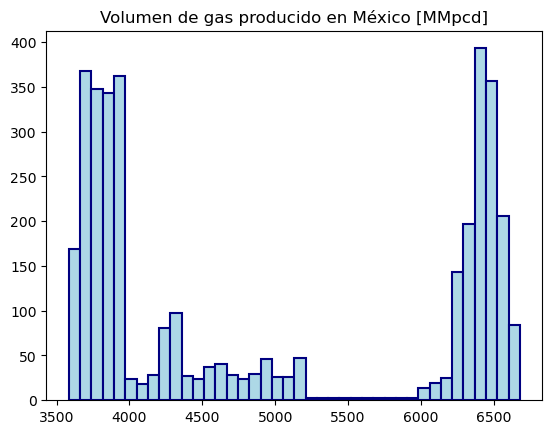

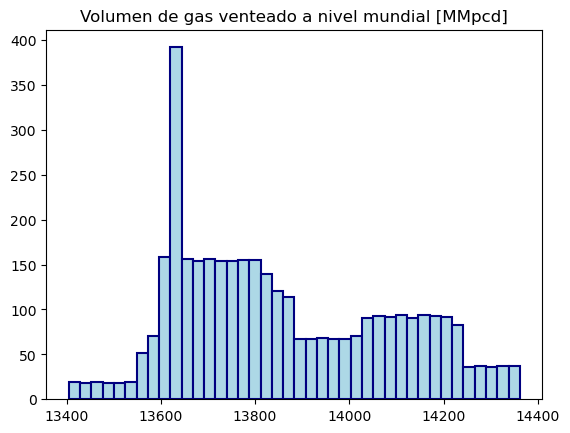

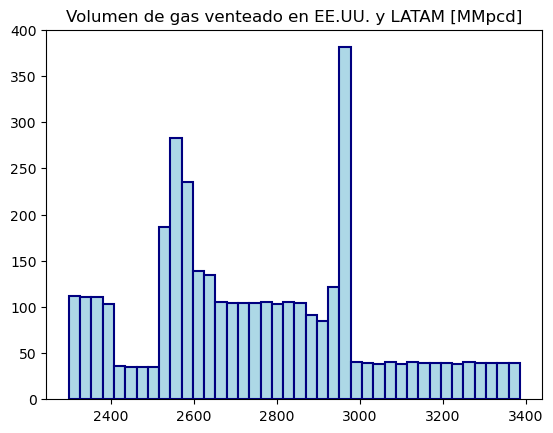

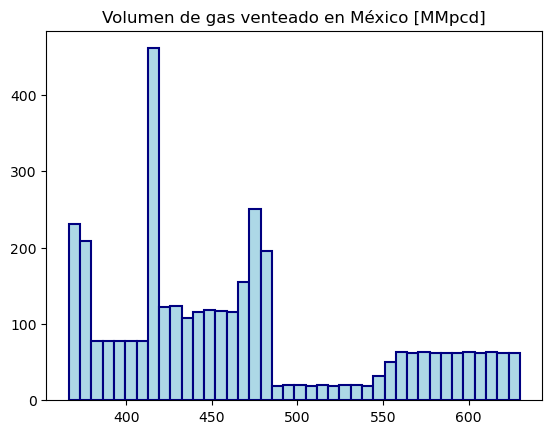

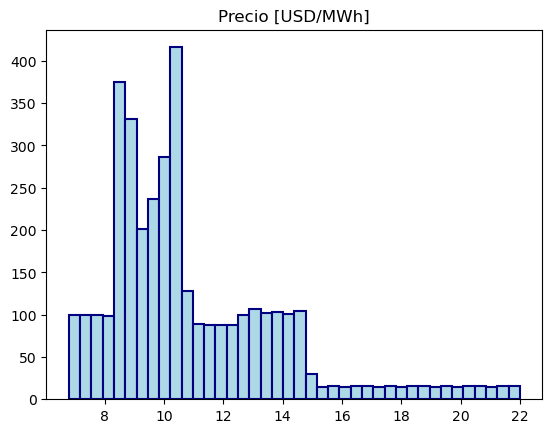

In [43]:
for i in range(1, no_col):
    
    nombre_columna = df_FlaringandProductionData.columns[i]
    serie          = df_FlaringandProductionData[nombre_columna].to_numpy()
    
    no_cajas = 40
    
    plt.figure()
    plt.hist(serie, bins = no_cajas, rwidth = 2, edgecolor = "navy", color = "lightblue", linewidth = 1.5)
    plt.title(nombre_columna)
    NamePlot = "Histograma %s .png" %str(i)  
    #plt.savefig(NamePlot, dpi = 500)

In [44]:
print(df_FlaringandProductionData)

          Fecha  Volumen de gas producido en México [MMpcd]  \
0    2012-01-01                                 6319.997618   
1    2012-01-02                                 6323.531913   
2    2012-01-03                                 6327.066207   
3    2012-01-04                                 6330.600502   
4    2012-01-05                                 6334.134796   
...         ...                                         ...   
3649 2021-12-28                                 3988.364943   
3650 2021-12-29                                 3989.896897   
3651 2021-12-30                                 3991.428850   
3652 2021-12-31                                 3992.960803   
3653 2022-01-01                                 3994.492756   

      Volumen de gas venteado a nivel mundial [MMpcd]  \
0                                        13823.666616   
1                                        13822.937879   
2                                        13822.209141   
3              

/Users/luiscedeno/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


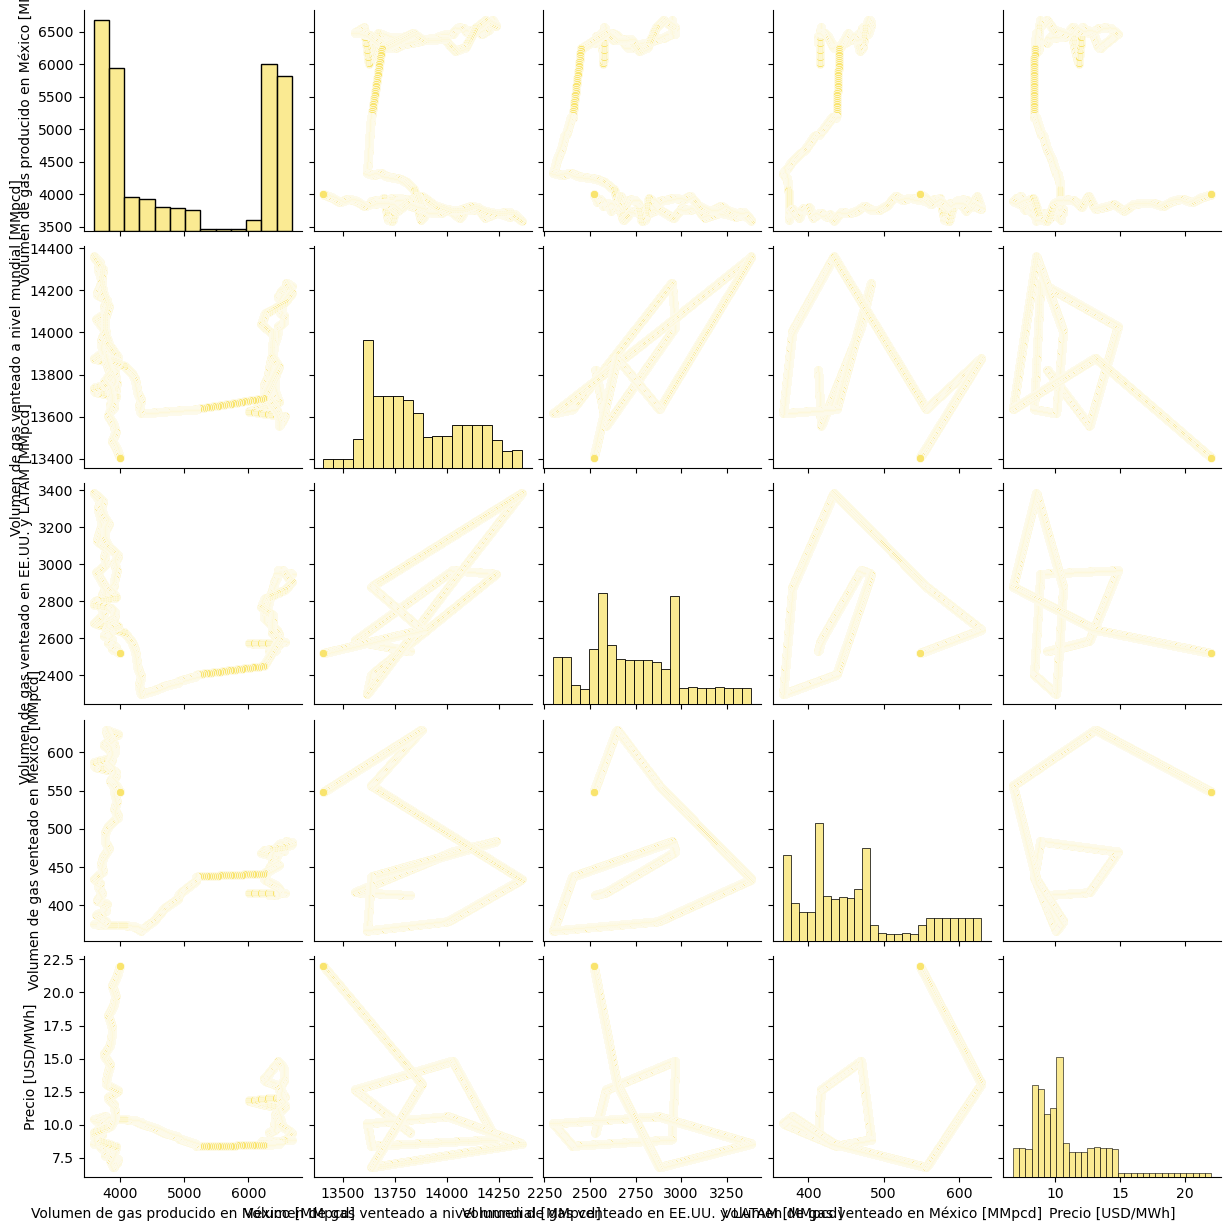

In [45]:
color = (sns.light_palette("#F9E46E", reverse = True))
sns.set_palette(color)
sns.pairplot(df_FlaringandProductionData)

Valor máximo de correlación:  0.9999922664691812  lag correspondiente:  1  -  Volumen de gas producido en México [MMpcd] - Volumen de gas producido en México [MMpcd]
Valor máximo de correlación:  0.3913904887789787  lag correspondiente:  1217  -  Volumen de gas producido en México [MMpcd] - Volumen de gas venteado a nivel mundial [MMpcd]
Valor máximo de correlación:  0.38812794279609014  lag correspondiente:  505  -  Volumen de gas producido en México [MMpcd] - Volumen de gas venteado en EE.UU. y LATAM [MMpcd]
Valor máximo de correlación:  0.947242547768503  lag correspondiente:  1188  -  Volumen de gas producido en México [MMpcd] - Volumen de gas venteado en México [MMpcd]
Valor máximo de correlación:  0.5941233871265551  lag correspondiente:  1217  -  Volumen de gas producido en México [MMpcd] - Precio [USD/MWh]
Valor máximo de correlación:  0.999986923105845  lag correspondiente:  1  -  Volumen de gas venteado a nivel mundial [MMpcd] - Volumen de gas venteado a nivel mundial [MMpcd]

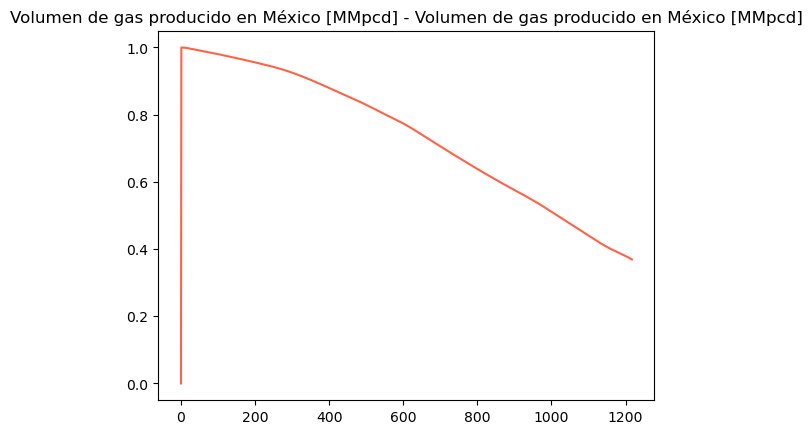

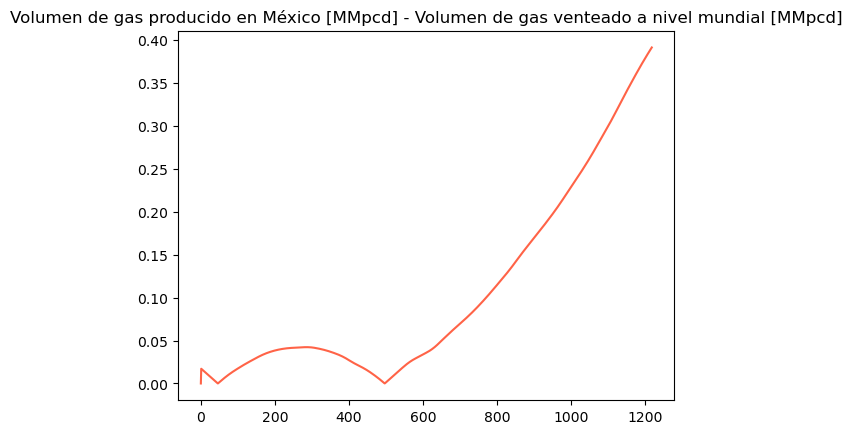

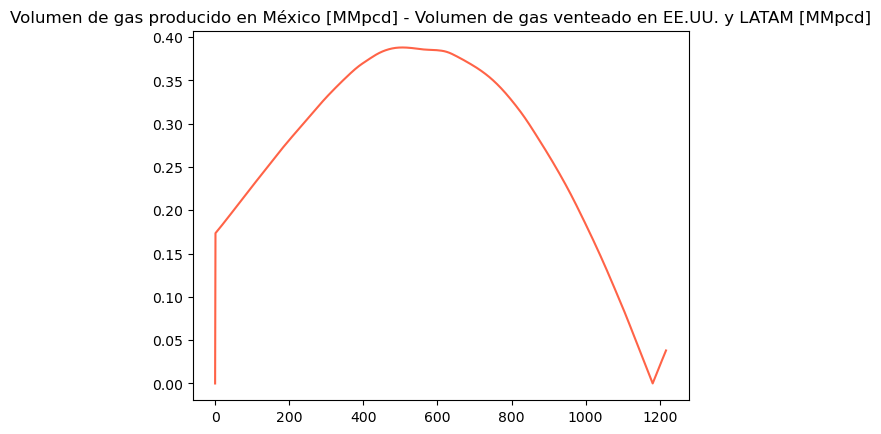

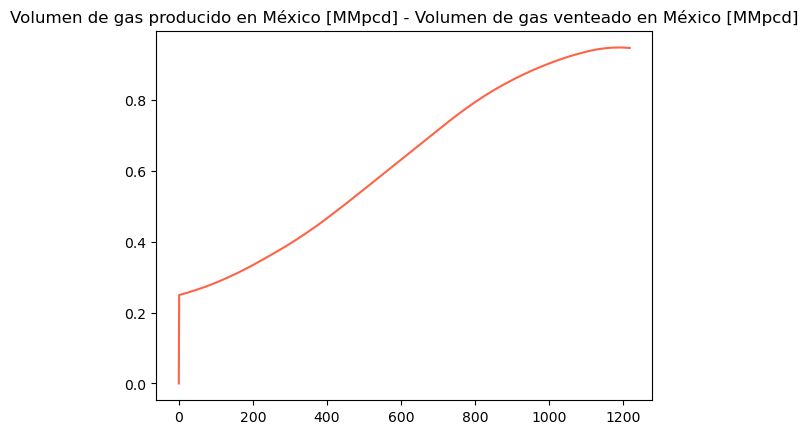

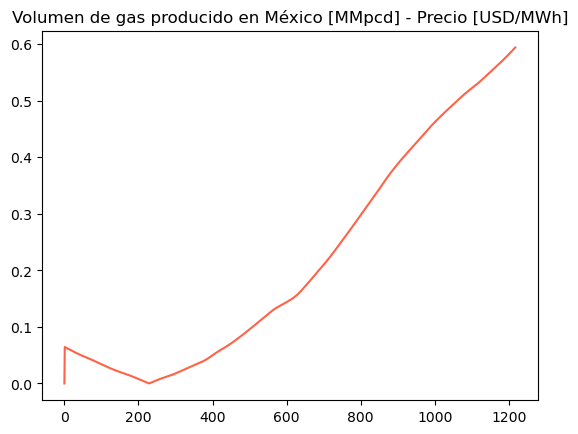

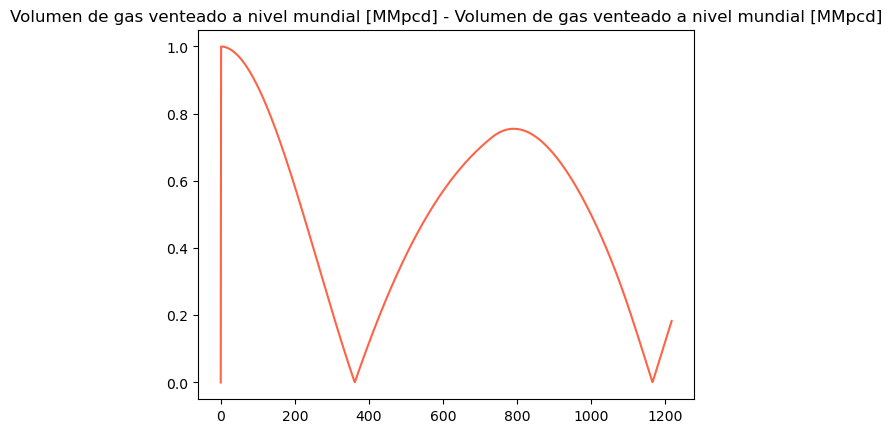

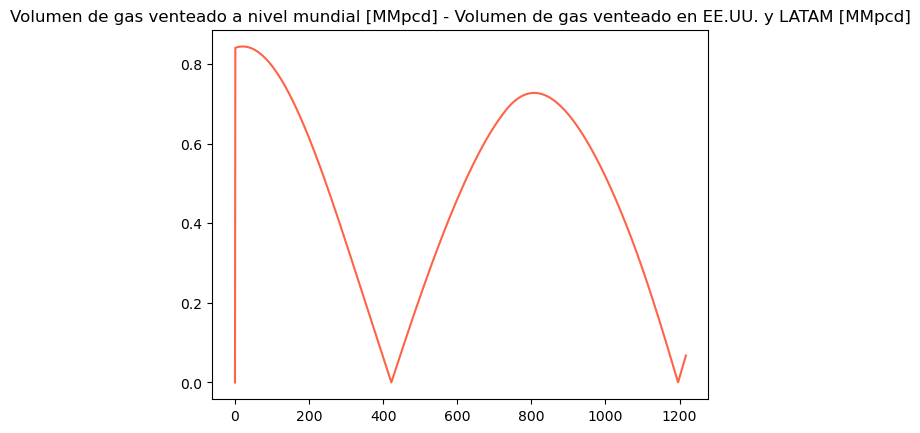

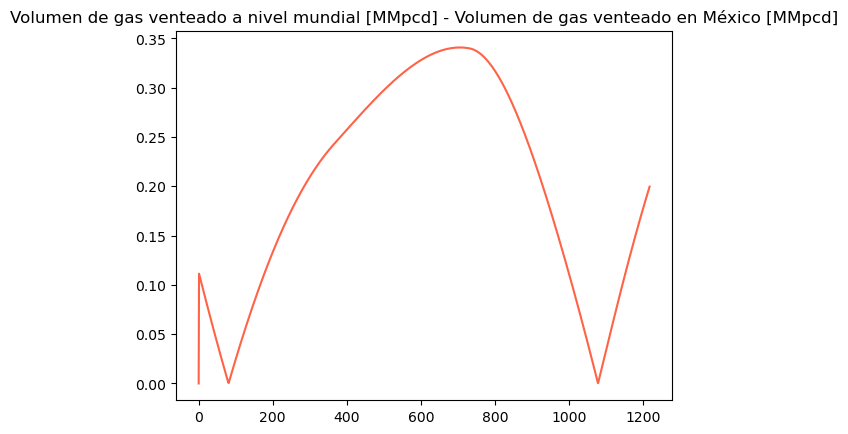

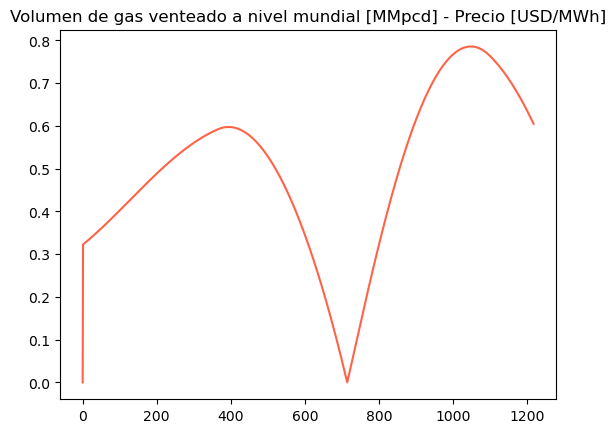

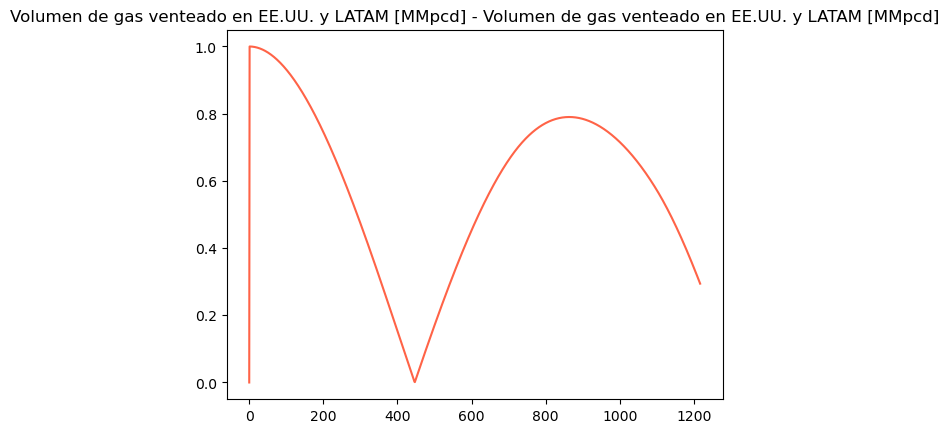

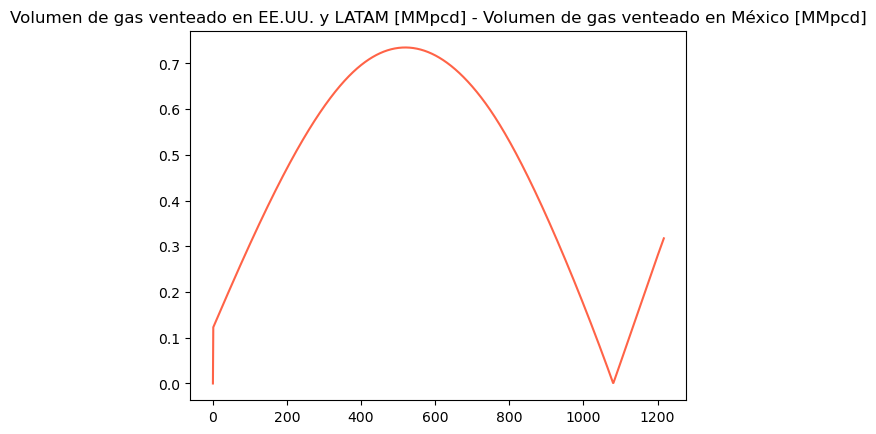

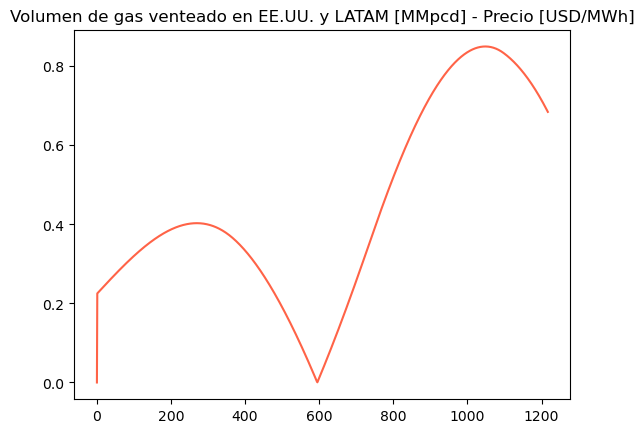

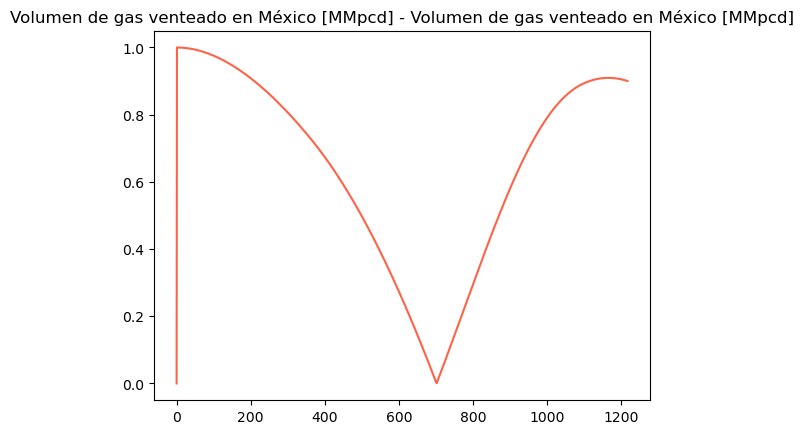

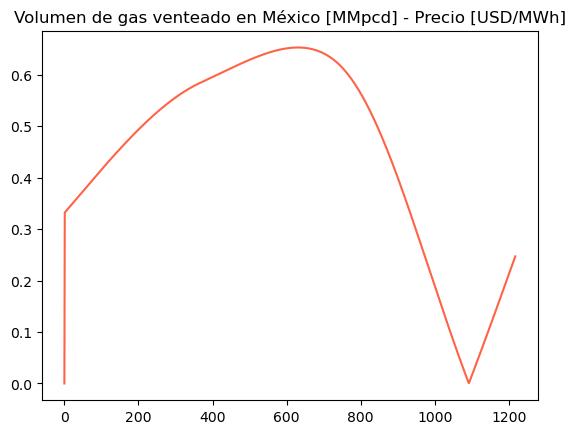

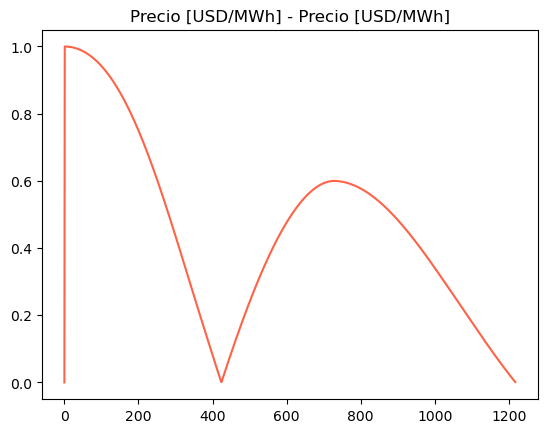

In [46]:
grado_corr = 0.6
lag_max    = int(no_datos/3.0)

lista = []

for i in range(1, no_col):
    
    nombre_columna1 = df_FlaringandProductionData.columns[i]
    serie1          = df_FlaringandProductionData[nombre_columna1].to_numpy()
    
    for j in range(i, no_col):
        
        nombre_columna2 = df_FlaringandProductionData.columns[j]
        serie2          = df_FlaringandProductionData[nombre_columna2].to_numpy()
        lags            = np.arange(lag_max)
        corr_vec        = np.zeros(lag_max)
        
        for k in range(1, lag_max): # lag
            
            X           = serie1[0:no_datos - k]
            Y           = serie2[k:no_datos]
            C           = np.corrcoef(X,Y)
            corr_vec[k] = abs(C[0, 1])
        
        plt.figure()
        plt.plot(lags, corr_vec, c = "tomato")
        plt.title(nombre_columna1 + ' - ' + nombre_columna2)
        #NamePlot = "Correlaciones %s .png" %str(i)  
        #plt.savefig(NamePlot, dpi = 500)
        
        valor_corr_max = max(corr_vec)
        
        if valor_corr_max > grado_corr:
            
            sirve_forecast = 1
        
        else:
            
            sirve_forecast = 0
        
        lag_principal = np.where(corr_vec == valor_corr_max)[0][0]
        
        print("Valor máximo de correlación: ", valor_corr_max, " lag correspondiente: ", lag_principal, " - ", nombre_columna1 + ' - ' + nombre_columna2)
        
        
        lista.append([nombre_columna1, nombre_columna2, i, j, lag_principal, valor_corr_max, sirve_forecast])

lista    = np.array(lista)
lista_df = pd.DataFrame(lista, columns = ['serie1', 'serie2', 'Col1', 'Col2', 'lag_principal', 'valor_correlacion', 'sirve'])

lista_df.to_csv('Correlaciones.csv')

In [47]:
val_max = np.zeros(no_col)
lag_vec = np.zeros(no_col)

for i in range(lista_df[lista_df.columns[0]].count()):
    
    if val_max[int(lista_df['Col1'][i])] < float(lista_df['valor_correlacion'][i]):
        
        val_max[int(lista_df['Col1'][i])] = float(lista_df['valor_correlacion'][i])
        lag_vec[int(lista_df['Col1'][i])] = int(lista_df['lag_principal'][i])

print(val_max)
print(lag_vec)

lag_max = int(max(lag_vec))

print(lag_max)

[0.             0.999992266469 0.999986923106 0.999992690126
 0.999997384868 0.999994755857]
[0. 1. 1. 1. 1. 1.]
1


In [48]:
modelX_mat = np.empty((0, no_datos - lag_max)) 
modelY_mat = np.empty((0, no_datos - lag_max)) 

for i in range(1, no_col):
    
    nombre_columna1 = df_FlaringandProductionData.columns[i]
    aux = df_FlaringandProductionData[nombre_columna1].to_numpy()[(lag_max - int(lag_vec[i])):(no_datos - int(lag_vec[i]))]
    modelX_mat = np.append(modelX_mat, np.array([aux]), axis=0)
    aux = df_FlaringandProductionData[nombre_columna1].to_numpy()[lag_max:no_datos]
    modelY_mat = np.append(modelY_mat, np.array([aux]), axis=0)

modelX_mat = modelX_mat.transpose()
modelY_mat = modelY_mat.transpose()

fecha_vec = df_FlaringandProductionData["Fecha"][lag_max:no_datos].to_numpy()

print(modelX_mat.shape, modelY_mat.shape)

(3653, 5) (3653, 5)


In [49]:
modelX_mat = modelX_mat.transpose()
modelY_mat = modelY_mat.transpose()

print(modelX_mat.shape[0])

min_vec = np.zeros(modelX_mat.shape[0])
max_vec = np.zeros(modelX_mat.shape[0])
modelX_normalizado = np.empty((0, no_datos - lag_max))
modelY_normalizado = np.empty((0, no_datos - lag_max))

for i in range(modelX_mat.shape[0]):
    
    min_vec[i] = np.min(np.concatenate((modelX_mat[i], modelY_mat[i])))
    max_vec[i] = np.max(np.concatenate((modelX_mat[i], modelY_mat[i])))
    aux = (modelX_mat[i] - min_vec[i])/(max_vec[i] - min_vec[i])
    modelX_normalizado = np.append(modelX_normalizado, np.array([aux]), axis=0)
    aux = (modelY_mat[i] - min_vec[i])/(max_vec[i] - min_vec[i])
    modelY_normalizado = np.append(modelY_normalizado, np.array([aux]), axis=0)

print(min_vec)
print(max_vec)

print(np.min(np.concatenate((modelX_normalizado[0], modelY_normalizado[0]))), np.max(np.concatenate((modelX_normalizado[0], modelY_normalizado[0]))))

modelX_mat = modelX_mat.transpose()
modelY_mat = modelY_mat.transpose()
modelX_normalizado = modelX_normalizado.transpose()
modelY_normalizado = modelY_normalizado.transpose()


5
[ 3584.516151675712 13405.056316060449  2299.050807721034
   366.595630817216     6.785043      ]
[ 6677.813393999979 14361.63177158581   3385.452804215653
   629.77388132611     21.99648       ]
0.0 1.0


In [50]:
train_porc = 0.75
no_datos_train = int(0.75*modelY_mat.shape[0])

print(no_datos_train)

trainX_mat = modelX_mat[0:no_datos_train, :]
testX_mat = modelX_mat[no_datos_train:modelY_mat.shape[0], :]

trainY_mat = modelY_mat[0:no_datos_train,:]
testY_mat = modelY_mat[no_datos_train:modelY_mat.shape[0], :]

trainX_normalizado = modelX_normalizado[0:no_datos_train, :]
testX_normalizado = modelX_normalizado[no_datos_train:modelY_mat.shape[0], :]

trainY_normalizado = modelY_normalizado[0:no_datos_train,:]
testY_normalizado = modelY_normalizado[no_datos_train:modelY_mat.shape[0], :]

fecha_train = fecha_vec[0:no_datos_train]
fecha_test = fecha_vec[no_datos_train:modelY_mat.shape[0]]


2739


In [51]:
### ╔════════════════════════════╗
### ║                            ║
### ║      Entrenamiento de      ║
### ║      Bosque aleatorio      ║
### ║                            ║
### ╚════════════════════════════╝

no_arboles = 100
inicio = time.time()
model = MultiOutputRegressor(RandomForestRegressor(n_estimators = no_arboles, max_depth = 5, random_state = 0))
model.fit(trainX_mat, trainY_mat)

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=5,
                                                     random_state=0))

El tiempo de ejecución fue de:  3.1040477752685547 [s]
(5, 2739) (5, 914) (5, 914)


<Figure size 640x480 with 0 Axes>

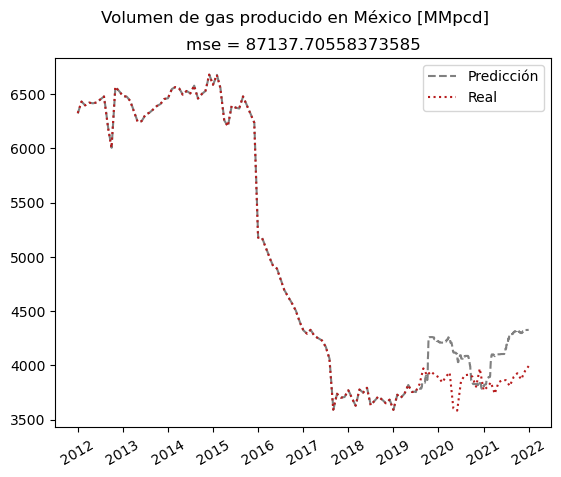

<Figure size 640x480 with 0 Axes>

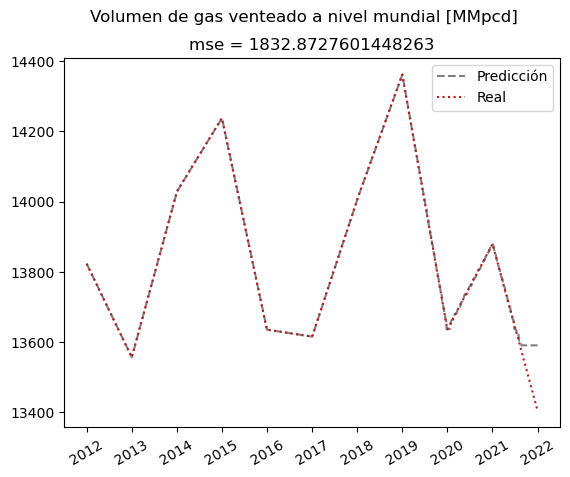

<Figure size 640x480 with 0 Axes>

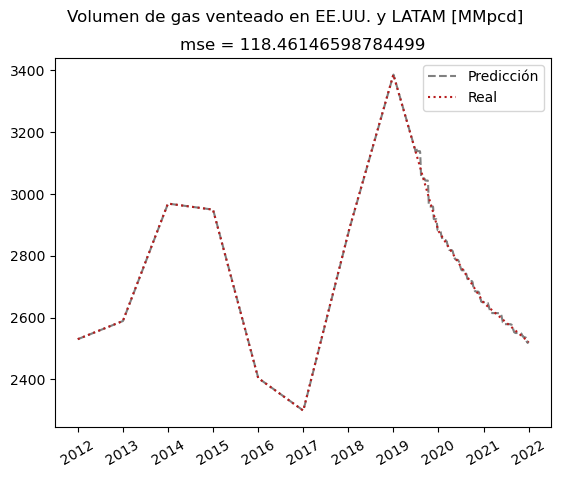

<Figure size 640x480 with 0 Axes>

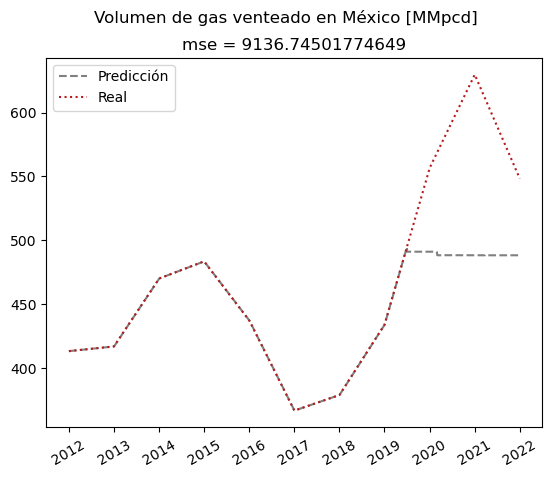

<Figure size 640x480 with 0 Axes>

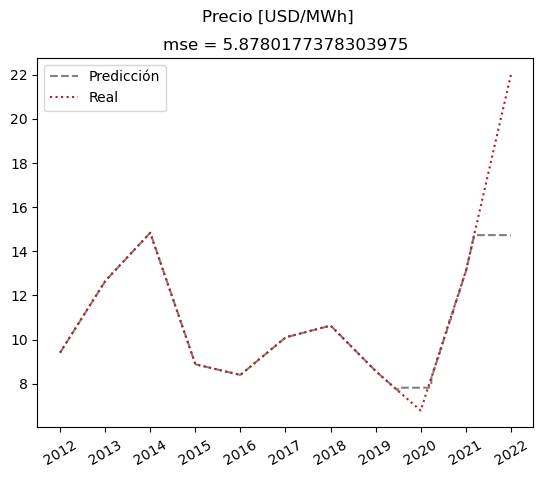

In [52]:
y_rf = model.predict(testX_mat)

trainX_mat = trainX_mat.transpose()
y_rf = y_rf.transpose()

trainY_mat = trainY_mat.transpose()
testY_mat = testY_mat.transpose()
fin = time.time()

print("El tiempo de ejecución fue de: ",fin - inicio, "[s]")

print(trainX_mat.shape,y_rf.shape, testY_mat.shape)
      
for i in range(1, no_col):
    
    nombre_columna1 = df_FlaringandProductionData.columns[i]
    
    plt.figure()
    fig, ax = plt.subplots()
    PlotDataX = np.concatenate((trainX_mat[i-1],y_rf[i-1]),axis=0)
    plt.plot(fecha_vec, PlotDataX, linestyle = "dashed", color = "gray", label="Predicción")
    PlotDataY = np.concatenate((trainY_mat[i-1],testY_mat[i-1]),axis=0)
    plt.plot(fecha_vec, PlotDataY, linestyle = "dotted", color = "#B71B1C", label="Real")
    plt.title("mse = " + str(mean_squared_error(y_rf[i-1], testY_mat[i-1])))
    plt.suptitle(nombre_columna1)
    ax.tick_params(axis = "x", labelrotation = 30)
    #NamePlot = "Gráfico - Bosque Aleatorio %s .png" %str(i)  
    #plt.savefig(NamePlot, dpi = 500)
    plt.legend()

In [53]:
### ╔════════════════════════════╗
### ║                            ║
### ║      Entrenamiento de      ║
### ║     Red Neuronal LSTM      ║
### ║                            ║
### ╚════════════════════════════╝ 


trainX_normalizado = np.reshape(trainX_normalizado, (trainX_normalizado.shape[0], trainX_normalizado.shape[1], 1))

no_neuronas = no_entradas = no_salidas = trainX_normalizado.shape[1]

print(no_entradas, no_salidas)

inicio = time.time()
model = Sequential()
model.add(LSTM(no_neuronas, activation = "linear", input_shape = (trainX_normalizado.shape[1], trainX_normalizado.shape[2])))
model.add(Dense(no_salidas))
model.compile(loss = "mse", optimizer = "Adam")
model.fit(trainX_normalizado, trainY_normalizado, epochs = 250, batch_size = 12, verbose = 0)

5 5


29/29 [==============================] - 0s 2ms/step
El tiempo de ejecución fue de:  119.98953080177307 [s]
(914,) (914,)
(914,) (914,)
(914,) (914,)
(914,) (914,)
(914,) (914,)
0.4413945849086992


<Figure size 640x480 with 0 Axes>

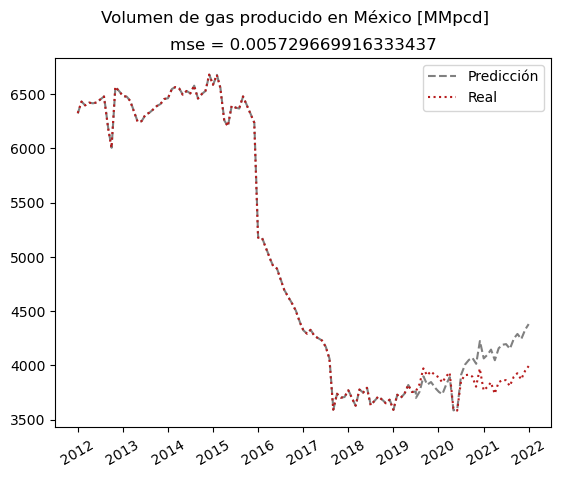

<Figure size 640x480 with 0 Axes>

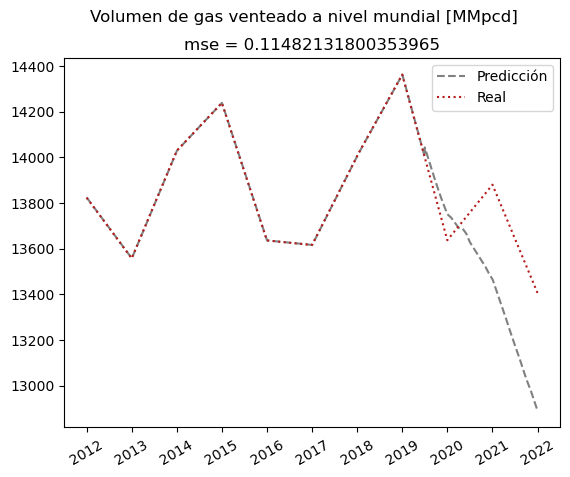

<Figure size 640x480 with 0 Axes>

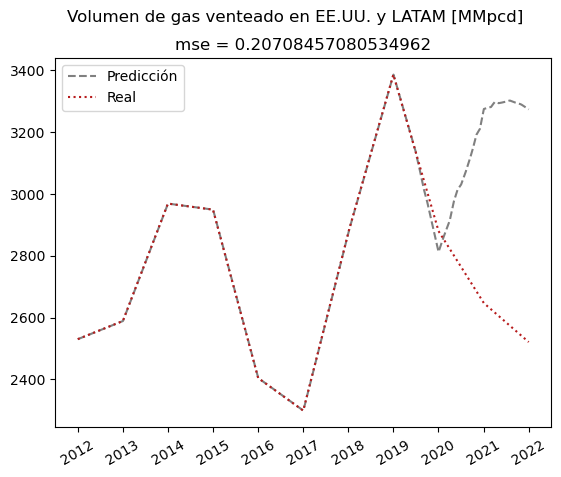

<Figure size 640x480 with 0 Axes>

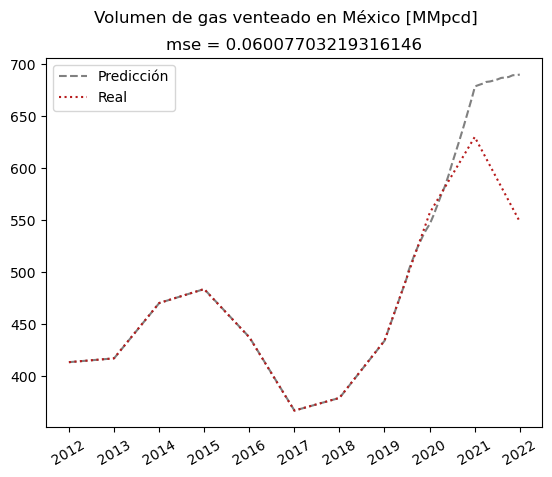

<Figure size 640x480 with 0 Axes>

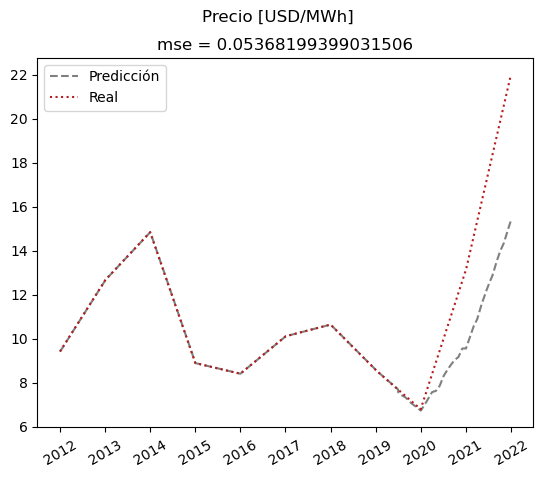

In [54]:
testX_normalizado = np.reshape(testX_normalizado, (testX_normalizado.shape[0], testX_normalizado.shape[1], 1))

y_rf = model.predict(testX_normalizado)

y_rf = y_rf.transpose()
testY_normalizado = testY_normalizado.transpose()
fin = time.time()

print("El tiempo de ejecución fue de: ",fin - inicio, "[s]")
error = 0

for i in range(1, no_col):
    
    nombre_columna1 = df_FlaringandProductionData.columns[i]
    
    plt.figure()
    fig, ax = plt.subplots()
    PlotDataX = np.concatenate((trainX_mat[i-1],(max_vec[i-1] - min_vec[i-1]) * y_rf[i-1] + min_vec[i-1]),axis=0)
    plt.plot(fecha_vec, PlotDataX, linestyle = "dashed", color = "gray", label="Predicción")
    PlotDataY = np.concatenate((trainY_mat[i-1],(max_vec[i-1] - min_vec[i-1])*testY_normalizado[i-1] + min_vec[i-1]),axis=0)
    plt.plot(fecha_vec, PlotDataY, linestyle = "dotted", color = "#B71B1C", label="Real")
    plt.title("mse = " + str(mean_squared_error(y_rf[i-1], testY_normalizado[i-1])))
    error = error + mean_squared_error(y_rf[i-1], testY_normalizado[i-1])
    plt.suptitle(nombre_columna1)
    ax.tick_params(axis = "x", labelrotation = 30)
    plt.legend()
    #NamePlot = "Gráfico - Red Neuronal Recurrente %s .png" %str(i)  
    #plt.savefig(NamePlot, dpi = 500)
    
    print(fecha_test.shape, testY_normalizado[i-1].shape)

print(error)

In [55]:
### ╔════════════════════════════╗
### ║                            ║
### ║      Entrenamiento de      ║
### ║        Red Neuronal        ║
### ║        Modular LSTM        ║
### ║                            ║
### ╚════════════════════════════╝ 

lista_RN = []

trainY_normalizado = trainY_normalizado.transpose()

trainX_normalizado = np.reshape(trainX_normalizado, (trainX_normalizado.shape[0], trainX_normalizado.shape[1], 1))

no_neuronas = no_entradas = trainX_normalizado.shape[1]
no_salidas = 1

print(no_entradas, no_salidas)

5 1


(5, 2739) (5, 914) (5, 2739) (5, 914)
29/29 [==============================] - 0s 2ms/step
El tiempo de ejecución fue de:  226.71299624443054 [s]
(3653,)
29/29 [==============================] - 0s 2ms/step
El tiempo de ejecución fue de:  226.9945011138916 [s]
(3653,)
29/29 [==============================] - 0s 2ms/step
El tiempo de ejecución fue de:  227.27747321128845 [s]
(3653,)
29/29 [==============================] - 0s 2ms/step
El tiempo de ejecución fue de:  227.607684135437 [s]
(3653,)
29/29 [==============================] - 0s 1ms/step
El tiempo de ejecución fue de:  227.88084411621094 [s]
(3653,)
427314.5542184813


<Figure size 640x480 with 0 Axes>

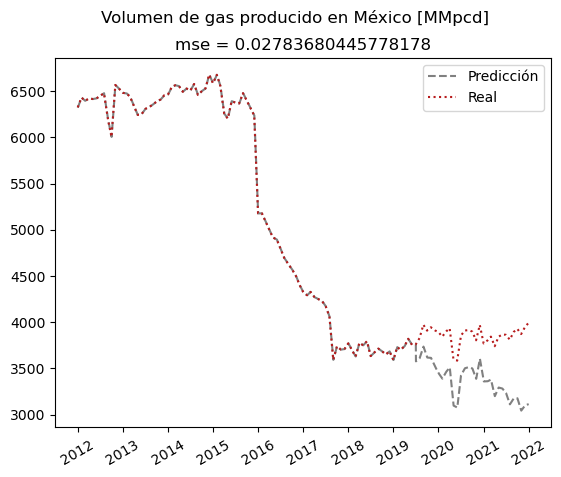

<Figure size 640x480 with 0 Axes>

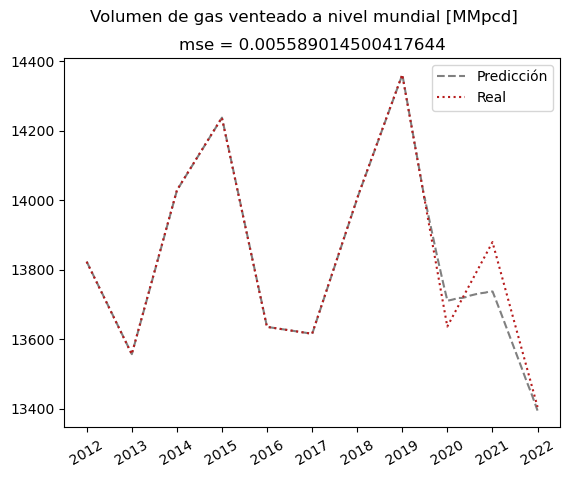

<Figure size 640x480 with 0 Axes>

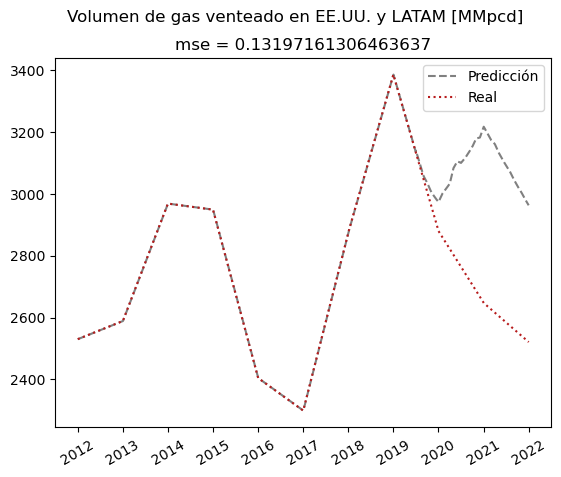

<Figure size 640x480 with 0 Axes>

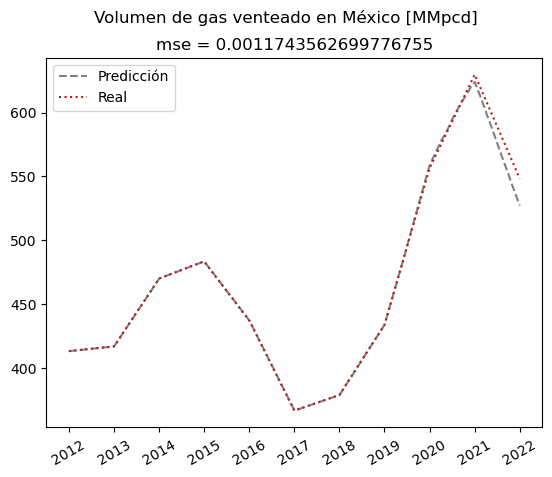

<Figure size 640x480 with 0 Axes>

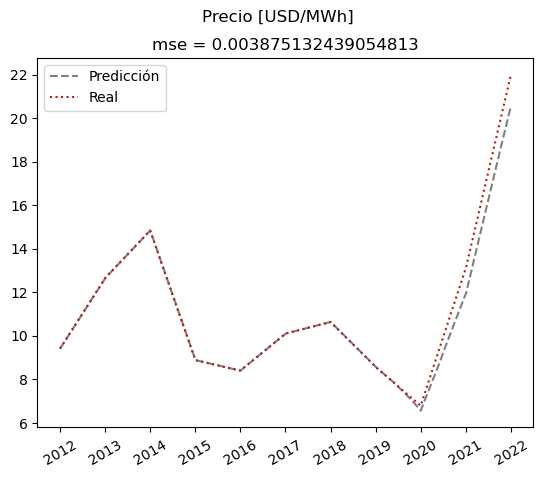

In [56]:
funcionesactiva  = ["linear","linear","linear","linear","linear"]
funcionesperdida = ["mse","mse","mse","mse","mse"]
optimizador      = ["Adam","Adam","Adam","Adam","Adam"]

inicio = time.time()

for i in range(1,no_col):
    
    array_salida = trainY_normalizado[i-1].transpose()
    model = Sequential()
    model.add(LSTM(no_neuronas, activation = funcionesactiva[i-1], input_shape = (trainX_normalizado.shape[1], trainX_normalizado.shape[2])))
    model.add(Dense(no_salidas))
    model.compile(loss = funcionesperdida[i-1], optimizer = optimizador[i-1])
    model.fit(trainX_normalizado, array_salida, epochs=100, batch_size=12, verbose=0)
    lista_RN.append(model)

testX_normalizado = np.reshape(testX_normalizado, (testX_normalizado.shape[0], testX_normalizado.shape[1], 1))  

error = 0

print(trainX_mat.shape,y_rf.shape,trainY_mat.shape,testY_normalizado.shape)

for i in range(1, no_col):
    
    y_rf = lista_RN[i-1].predict(testX_normalizado)
    y_rf = y_rf.transpose()
    nombre_columna1 = df_FlaringandProductionData.columns[i]
    
    fin = time.time()

    print("El tiempo de ejecución fue de: ",fin - inicio, "[s]")
    
    plt.figure() 
    fig, ax = plt.subplots()
    np.resize(y_rf,(0))
    PlotDataX = np.concatenate((trainX_mat[i-1],((max_vec[i-1] - min_vec[i-1]) * y_rf[0,:] + min_vec[i-1])),axis=0)
    print(PlotDataX.shape)
    plt.plot(fecha_vec, PlotDataX, linestyle = "dashed", color = "gray", label="Predicción")
    PlotDataY = np.concatenate((trainY_mat[i-1],(max_vec[i-1] - min_vec[i-1])*testY_normalizado[i-1] + min_vec[i-1]),axis=0)
    plt.plot(fecha_vec, PlotDataY, linestyle = "dotted", color = "#B71B1C", label="Real")
    plt.title(funcionesperdida[i-1] + " = "+ str(mean_squared_error(y_rf[0,:], testY_normalizado[i-1])))
    error = error + mean_squared_error((max_vec[i-1] - min_vec[i-1])*y_rf[0,:] + min_vec[i-1], (max_vec[i-1] - min_vec[i-1])*testY_normalizado[i-1] + min_vec[i-1])
    plt.suptitle(nombre_columna1)
    ax.tick_params(axis = "x", labelrotation = 30)
    plt.legend()
    #NamePlot = "Gráfico - Red Neuronal Modular %s .png" %str(i)  
    #plt.savefig(NamePlot, dpi = 500)

print(error)